# Jupyter notebook: sgRNA sequence motifs correlating with repression strength

## Overview

This Jupyter notebook is an attempt to identify sequence motifs or variants in sgRNAs that improve or decrease the efficiency of CRISPRi reression.

## Background

Two CRISPRi libraries are available for Synechocystis, version 1.0 with only 2 sgRNAs and version 2.0 with on average 5 sgRNAs per gene.
Each sgRNA targets the 5'-region of a gene, meaning the transcription start site (TSS) or the region downstream of it.
The sgRNA mediates the binding efficiency of the dCas9 enzyme. However, previous and current sequencing results show that the repression strength is by no means uniform.
In fact, variation between the efficiency of sgRNAs mediating repression is enormous. Repression efficiency is partly influenced by the distance to the TSS, and partly
by unknown sequence features. Such features could be:

- folding, secondary structures, such as hairpins
- off target binding (competitive binding)
- GC content
- so far unknown motifs

For details regarding the ongoing efforts to determine all gene's fitness contribution, see the [CRISPRi library github repository](https://github.com/m-jahn/R-notebook-crispri-lib) that contains this notebook and further information. The R analysis pipeline that led to the selection of the ncRNAs of interest can be viewed on [m-jahn.github.io](https://m-jahn.github.io/R-notebook-crispri-lib/CRISPRi_V2_data_processing.nb.html).

Tasks:

- import sgRNA sequences
- import sgRNA fitness data and merge with sequences
- group sgRNAs in different binding classes (or continuous target variable?)
- determine sequence motifs that lead to high repression efficiency and/or correlation
- determine sequence motifs that lead to low repression

Strategy:

- nucleotide sequence is available, needs to be trimmed and aligned
- can be one-hot-encoded by position and nucleotide (pos1_A: T/F, pos1_T: T/F, ...)
- test and apply different ML models:
  - tree-based models including feature importance: Random Forest (RF), gradient boosting (GB)
  - NN-based models without feature importance: MLP, CNN


## Setting up python environment


We will use micromamba (or mamba/conda) to generate a reproducible environment for machine learning.
In order to do this, create a fresh conda environment:

```
micromamba create -n machine-learning -c conda-forge
source /path/to/micromamba/bin/activate
conda activate machine-learnin
```


Now install the required basic packages:

```
micromamba install -c conda-forge pandas numpy matplotlib biopython viennarna logomaker ipykernel
```


And install the required machine learning packages:

```
micromamba install -c conda-forge scikit-learn tensorflow keras
```


## Import of required libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import Bio.SeqIO
import Bio.SeqUtils
import subprocess
from requests import get
from io import StringIO

## Data import and re-arrangement

The first task is to import the sequence data from a fasta file into a data frame.
The data is stored as reference "genome" for read mapping, in the [CRISPRi NGS pipeline](https://github.com/m-jahn/CRISPRi-lib-pipe/) on github.


In [2]:
dir_fasta_db = (
    "https://github.com/m-jahn/CRISPRi-lib-pipe/raw/main/ref/Synechocystis_v2.fasta"
)
con_fasta_db = get(dir_fasta_db, allow_redirects=True)
fasta_db = Bio.SeqIO.parse(StringIO(con_fasta_db.text), "fasta")

- remove the 10 control sgRNAs that are not mapping to anything


In [3]:
fasta_db = [i for i in fasta_db if not i.id.startswith("ctrl")]

- import the reference genome of _Synechocystis_ sp. PCC 6803.


In [4]:
from Bio.Seq import Seq

ref_genome = Bio.SeqIO.parse(
    "../data/input/Synechocystis_PCC6803_NC_000911.gbk", "genbank"
)
ref_genome = list(ref_genome)
ref_genome = Seq("").join([i.seq for i in ref_genome])

The next code chunk is important. It loops though the fasta database and, for each guide RNA:

- trims adapters away
- finds position in genome
- determines orientation (0: template strand, 1: non-template strand = rev-com match)
- extracts core sequence
- extracts 10 nt leading and trailing sequences


In [5]:
# adapters to remove
fivep_adapter = "CAGTGATAGAGATACTGGGAGCTA"
threep_adapter = "GTTTTAGAGCTAGAAATAGCAAGTTAAAAT"

# result data frame
fasta_df = pd.DataFrame(
    columns=[
        "sgRNA",
        "strand",
        "seq",
        "seq_5p",
        "seq_3p",
        "seq_total",
        "len_seq",
        "len_total",
    ]
)

# process sgrnas
for fasta_record in fasta_db:
    threep_pos = fasta_record.seq.find(threep_adapter)
    sgrna = fasta_record.seq[len(fivep_adapter) : threep_pos]
    if ref_genome.find(sgrna) != -1:
        sgrna_strand = 0
        ref_genome_local = ref_genome
    else:
        ref_genome_local = ref_genome.reverse_complement()
        sgrna_strand = 1
    start_site = ref_genome_local.find(sgrna)
    end_site = start_site + len(sgrna)
    if start_site == -1 or end_site == -1:
        print(fasta_record.id, sgrna, start_site, end_site)
        raise Exception
    fivep_flank = ref_genome_local[start_site - (30 - len(sgrna)) : start_site]
    threep_flank = ref_genome_local[end_site : end_site + 11]
    new_row = pd.DataFrame(
        {
            "sgRNA": fasta_record.id,
            "strand": sgrna_strand,
            "seq": str(sgrna),
            "seq_5p": str(fivep_flank),
            "seq_3p": str(threep_flank),
            "seq_total": str(fivep_flank) + str(sgrna) + str(threep_flank),
            "len_seq": len(sgrna),
            "len_total": len(sgrna) + len(fivep_flank) + len(threep_flank),
        },
        index=[0],
    )
    fasta_df = pd.concat([fasta_df.loc[:], new_row]).reset_index(drop=True)

In [6]:
fasta_df.head(5)

,sgRNA,strand,seq,seq_5p,seq_3p,seq_total,len_seq,len_total
0,sll1677|130,0,CGCTGTCCCGGCACTTTCAA,AAAGTTCCAC,TGGCGGCCTCC,AAAGTTCCACCGCTGTCCCGGCACTTTCAATGGCGGCCTCC,20,41
1,sll1677|88,0,TTTGCCCGTCACCGTCC,TCACTGCTTCAAT,CGGCTATCACC,TCACTGCTTCAATTTTGCCCGTCACCGTCCCGGCTATCACC,17,41
2,sll1677|7,0,CTTCCCCATCCCAGACG,CCCCTAGGGTAAA,GGGAAAGCACG,CCCCTAGGGTAAACTTCCCCATCCCAGACGGGGAAAGCACG,17,41
3,sll1677|31,0,ATGTAGTTGAGCATAACCCCTA,CAAACCAA,GGGTAAACTTC,CAAACCAAATGTAGTTGAGCATAACCCCTAGGGTAAACTTC,22,41
4,sll1677|163,0,GCCATAATGCCAATCAAACCAA,ACCACAGG,TGGAAAGTTCC,ACCACAGGGCCATAATGCCAATCAAACCAATGGAAAGTTCC,22,41


Then, we add some extra features determined from sgRNA sequence or position:

- binding energy/ḱinetics using `CRISPRoff` score [1, 2]
- GC content
- melting temperature
- distance to promoter

References for `CRISPRoff` score:

1. Xiang et al., Enhancing CRISPR-Cas9 gRNA efficiency prediction by data integration and deep learning. Nature Communications, 2021. https://doi.org/10.1038/s41467-021-23576-0.
2. Alkan et al., CRISPR-Cas9 off-targeting assessment with nucleic acid duplex energy parameters. Genome Biol, 2018.

The `CRISPRoff` score is calculated using the CRISPRoff pipeline downloaded from https://github.com/RTH-tools/crisproff, and the `RNAfold` tool contained in the `viennaRNA` package (installed through conda/mamba previously). Documentation for viennaRNA is [on github](https://github.com/ViennaRNA/ViennaRNA).

In order to calculate `CRISPRoff` score, guide RNAs need to be exported as fasta file with a specific format. Every gRNA needs to be exactly 23 nt long, 20 nt spacer + 3 nt PAM site (`NGG`). Then CRISPRoff scores are calculated and results imported again.


In [7]:
with open("/home/michael/Downloads/crisproff-1.1.2/input.fa", "w") as fasta_export:
    for index, row in fasta_df.iterrows():
        pasted_seq = row["seq_5p"] + row["seq"] + row["seq_3p"][0:3]
        fasta_line = ">{0}\n{1}\n".format(row["sgRNA"], pasted_seq[-23:])
        fasta_export.write(fasta_line)

In [8]:
subprocess.getoutput(
    "cd /home/michael/Downloads/crisproff-1.1.2/;"
    + "python CRISPRspec_CRISPRoff_pipeline.py "
    + "--guides input.fa "
    + "--no_azimuth "
    + "--guide_params_out 'CRISPRoff_results.tsv'"
)

'#START: PIPELINE RUN HAS STARTED.\n#STEP 1: arguments parsed\n#ARG: comment_out_NAs = False\n#ARG: duplex_energy_params = energy_dics.pkl\n#ARG: evaluate_all = False\n#ARG: guide_params_out = CRISPRoff_results.tsv\n#ARG: guides = input.fa\n#ARG: no_azimuth = True\n#ARG: no_off_target_counts = False\n#ARG: rnafold_x = RNAfold\n#ARG: sorted_CRISPRoff_reports = False\n#ARG: specificity_report = stdout\n#STEP 2: energy parameters parsed from "energy_dics.pkl"\n#STEP 3: 21460 guides read/generated from "input.fa"\n#STEP 4: on-target features have been recorded in "CRISPRoff_results.tsv"\n#WARNING: Skipping STEP 5 (NO off-target assessment report for the guides). \n#STEP 5: Skipping. No output file specificied and/or No folder given for risearch results.\n#END: FINISHED RUNNING THE PIPELINE WITH NO ERROR.'

In [7]:
df_crisproff = pd.read_table(
    "/home/michael/Downloads/crisproff-1.1.2/CRISPRoff_results.tsv"
)
df_crisproff = df_crisproff.rename(
    columns={"guideID": "sgRNA", "CRISPRoff_score": "crisproff"}
)
df_crisproff = df_crisproff[["sgRNA", "crisproff"]].set_index("sgRNA")
fasta_df = fasta_df.set_index("sgRNA")
fasta_df = fasta_df.join(df_crisproff).reset_index()

In [8]:
# add melting temp
from Bio.SeqUtils import MeltingTemp

fasta_df["t_melt"] = fasta_df["seq"].apply(lambda x: "%0.2f" % MeltingTemp.Tm_NN(x))

# add GC content
from Bio.SeqUtils import gc_fraction

fasta_df["gc"] = fasta_df["seq"].apply(lambda x: gc_fraction(x))

# add sgRNA distance to promoter
fasta_df["dist"] = fasta_df["sgRNA"].apply(lambda x: int(x.split("|")[1]))

In [9]:
fasta_df.head(5)

,sgRNA,strand,seq,seq_5p,seq_3p,seq_total,len_seq,len_total,crisproff,t_melt,gc,dist
0,sll1677|130,0,CGCTGTCCCGGCACTTTCAA,AAAGTTCCAC,TGGCGGCCTCC,AAAGTTCCACCGCTGTCCCGGCACTTTCAATGGCGGCCTCC,20,41,17.935032,57.84,0.600000,130
1,sll1677|88,0,TTTGCCCGTCACCGTCC,TCACTGCTTCAAT,CGGCTATCACC,TCACTGCTTCAATTTTGCCCGTCACCGTCCCGGCTATCACC,17,41,18.397061,54.28,0.647059,88
2,sll1677|7,0,CTTCCCCATCCCAGACG,CCCCTAGGGTAAA,GGGAAAGCACG,CCCCTAGGGTAAACTTCCCCATCCCAGACGGGGAAAGCACG,17,41,23.026051,50.48,0.647059,7
3,sll1677|31,0,ATGTAGTTGAGCATAACCCCTA,CAAACCAA,GGGTAAACTTC,CAAACCAAATGTAGTTGAGCATAACCCCTAGGGTAAACTTC,22,41,20.851128,50.34,0.409091,31
4,sll1677|163,0,GCCATAATGCCAATCAAACCAA,ACCACAGG,TGGAAAGTTCC,ACCACAGGGCCATAATGCCAATCAAACCAATGGAAAGTTCC,22,41,17.282642,52.26,0.409091,163


The second task is to import the main data table with fitness, correlation and repression efficiency for every sgRNA.


In [10]:
data = pd.read_csv("../data/output/fitness_sgRNA.csv")
data.iloc[:, 0:14].head(n=5)

,sgRNA,sgRNA_target,sgRNA_position,condition,time,log2FoldChange,fitness,sgRNA_index,sgRNA_type,locus,sgRNA_correlation,sgRNA_efficiency
0,aat|111,aat,111,"HC, HL",0,0.000000,-0.534836,4,gene,sll0869,0.511205,1.0
1,aat|111,aat,111,"HC, HL",4,-0.369240,-0.534836,4,gene,sll0869,0.511205,1.0
2,aat|111,aat,111,"HC, HL",8,-0.338196,-0.534836,4,gene,sll0869,0.511205,1.0
3,aat|111,aat,111,"HC, HL",10,-0.182635,-0.534836,4,gene,sll0869,0.511205,1.0
4,aat|111,aat,111,"HC, IL",0,0.000000,-0.251155,4,gene,sll0869,0.511205,1.0


The data frame needs to be reduced/summarized to the desired shape. We don't need fitness and log2FC for all conditions and time points.
All we need instead is 1 sgRNA per row, with:

- mean absolute fitness effect over all conditions
- repression efficiency (relative score between 0 and 1)
- correlation (also relative score between 0 and 1)


In [11]:
data_reduced = data[
    [
        "sgRNA",
        "sgRNA_target",
        "sgRNA_position",
        "sgRNA_correlation",
        "sgRNA_efficiency",
        "fitness",
    ]
]

In [12]:
data_reduced = data_reduced.drop_duplicates()

In [13]:
# summarize all sgRNAs to mean abs fitness etc
data_reduced["fitness"] = abs(data_reduced["fitness"])
data_reduced = data_reduced.groupby(["sgRNA_target", "sgRNA"]).mean()

## Preparation for ML training and tuning

1. Remove non-responsive genes (no sgRNA has an effect on fitness)
2. Choose and optionally scale/bin target variable
3. One-hot encode sgRNA sequences
4. Split data into training and test data set

### Task 1: Remove non-responsive genes

Plot distribution of sgRNA fitness.


(array([1.0639e+04, 2.0310e+03, 9.1500e+02, 6.2000e+02, 4.5900e+02,
        3.6000e+02, 2.8300e+02, 2.2700e+02, 1.9400e+02, 1.8400e+02,
        1.2700e+02, 9.4000e+01, 8.7000e+01, 6.1000e+01, 4.6000e+01,
        3.8000e+01, 2.8000e+01, 1.5000e+01, 2.2000e+01, 1.4000e+01,
        1.1000e+01, 7.0000e+00, 4.0000e+00, 5.0000e+00, 3.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.04177192, 0.3573245 , 0.67287707, 0.98842965, 1.30398223,
        1.61953481, 1.93508739, 2.25063997, 2.56619254, 2.88174512,
        3.1972977 , 3.51285028, 3.82840286, 4.14395544, 4.45950801,
        4.77506059, 5.09061317, 5.40616575, 5.72171833, 6.03727091,
        6.35282348, 6.66837606, 6.98392864, 7.29948122, 7.6150338 ,
        7.93058637, 8.24613895, 8.56169153, 8.87724411, 9.19279669,
        9.50834927]),
 <BarContainer object of 30 artists>)

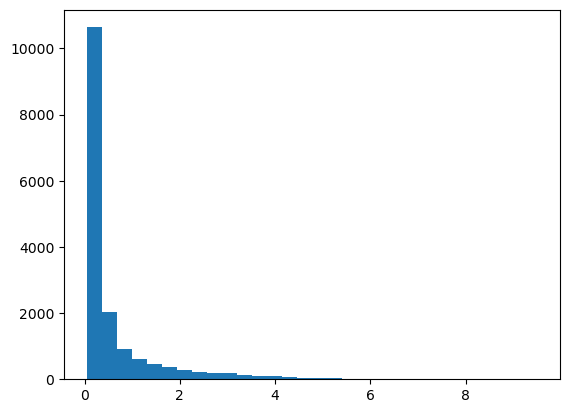

In [14]:
plt.hist(abs(data_reduced["fitness"]), bins=30)

(array([1.0639e+04, 2.0310e+03, 9.1500e+02, 6.2000e+02, 4.5900e+02,
        3.6000e+02, 2.8300e+02, 2.2700e+02, 1.9400e+02, 1.8400e+02,
        1.2700e+02, 9.4000e+01, 8.7000e+01, 6.1000e+01, 4.6000e+01,
        3.8000e+01, 2.8000e+01, 1.5000e+01, 2.2000e+01, 1.4000e+01,
        1.1000e+01, 7.0000e+00, 4.0000e+00, 5.0000e+00, 3.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.04177192, 0.3573245 , 0.67287707, 0.98842965, 1.30398223,
        1.61953481, 1.93508739, 2.25063997, 2.56619254, 2.88174512,
        3.1972977 , 3.51285028, 3.82840286, 4.14395544, 4.45950801,
        4.77506059, 5.09061317, 5.40616575, 5.72171833, 6.03727091,
        6.35282348, 6.66837606, 6.98392864, 7.29948122, 7.6150338 ,
        7.93058637, 8.24613895, 8.56169153, 8.87724411, 9.19279669,
        9.50834927]),
 <BarContainer object of 30 artists>)

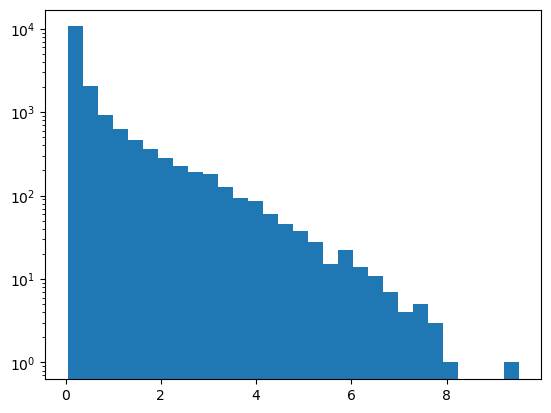

In [15]:
plt.hist(abs(data_reduced["fitness"]), bins=30, log=True)

In [16]:
# filter all genes out where no sgRNA exceeds fitness effect > 1 in any condition
list_max_fitness = data_reduced.groupby("sgRNA_target")["fitness"].max()

In [17]:
list_max_fitness = list_max_fitness[abs(list_max_fitness) > 1]

In [18]:
data_reduced = data_reduced.reset_index().merge(list_max_fitness, on="sgRNA_target")
data_reduced.head(5)

,sgRNA_target,sgRNA,sgRNA_position,sgRNA_correlation,sgRNA_efficiency,fitness_x,fitness_y
0,Era,Era|10,10.0,0.978652,0.312526,0.957018,3.477254
1,Era,Era|25,25.0,0.969941,0.646996,1.832944,3.477254
2,Era,Era|39,39.0,0.971285,0.203052,0.815705,3.477254
3,Era,Era|64,64.0,0.975519,0.288194,0.890238,3.477254
4,Era,Era|76,76.0,0.616163,1.000000,3.477254,3.477254


### Task 2: Scale and bin target variable

Target variable is sgRNA efficiency, a relative score between 0 (no effect on fitness) and 1 (maximum effect on fitness).
Scaling can therefore be omitted.

- if target variable is taken as is, the ML problem becomes a regression problem
- if target variable is binned into e.g. 5 bins of width 0.2, the problem becomes a classification problem
- choose simplest possible classification in high and low efficcieny sgRNAs


In [19]:
list_bins = ["0-low", "1-high"]
data_reduced["efficiency_binned"] = pd.cut(
    data_reduced["sgRNA_efficiency"], len(list_bins), labels=list_bins
)

<BarContainer object of 2 artists>

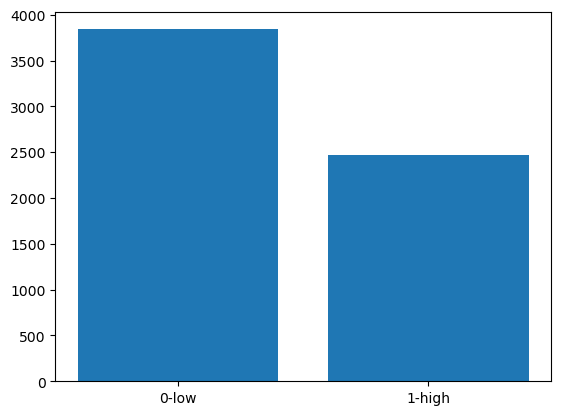

In [20]:
data_bin_sum = data_reduced.groupby("efficiency_binned").size()
plt.bar(x=data_bin_sum.index, height=data_bin_sum)

### Task 3: Prepare feature matrix

- For sequence-based features, we use the entire sgRNA region: 5'-flank (10-15) | spacer (17-22) | PAM-site (3) | 3'-flank (10)
- alternative is to pad shorter guideRNA spcacers with 0-5 N nucleotides (currently not done)
- One hot encoding of sgRNA sequences
- rescaling of the other non-sequence based features to range between 0 and 1


In [25]:
# filter fasta df to only sgRNAs that show an effect (common set with data)
fasta_df_reduced = pd.merge(fasta_df, data_reduced, how="inner", on="sgRNA")
print(min(fasta_df_reduced.len_seq), max(fasta_df_reduced.len_seq))

17 22


- export processed data frame

In [27]:
fasta_df_reduced.to_csv("../data/output/table_ml_features.csv")

**Shape of the sequence data as input for scikit learn**

- data is always a 2D array, shape (n_samples, n_features)
- features should be **one hot encoded**: all cateogrical variables are spread to a list/array with binary encoding (0 OR 1) for yes and no


In [24]:
def onehot(s):
    z = []
    for nt in str(s):
        if not nt in "AaCcGgTt":
            print("Non-ATGC character: " + nt, "sgRNA: " + s)
            raise Exception
        if nt in "Aa":
            z.append(1)
        else:
            z.append(0)
        if nt in "Cc":
            z.append(1)
        else:
            z.append(0)
        if nt in "Gg":
            z.append(1)
        else:
            z.append(0)
        if nt in "Tt":
            z.append(1)
        else:
            z.append(0)
    return z


fasta_df_reduced["seq_onehot"] = fasta_df_reduced.seq_total.apply(onehot)

- other non-sequence features are rescaled to a mean of 0 and standard deviation of 1


In [25]:
array_other = fasta_df_reduced[
    ["len_seq", "crisproff", "t_melt", "gc", "dist"]
].to_numpy()
from sklearn import preprocessing

sklearn_scaler = preprocessing.StandardScaler().fit(array_other)
array_other = sklearn_scaler.transform(array_other)

# check mean and standard deviation
print(array_other.mean(axis=0))
print(array_other.std(axis=0))

[-9.28460536e-16 -9.17192811e-16 -1.34536636e-15 -8.18036832e-16
 -1.08170160e-16]
[1. 1. 1. 1. 1.]


- finally turn pd.Series/DF into an array with dimensions n_observations x n_features
- also turn target variable into an array of length n_observations


In [26]:
array_fasta = np.array(fasta_df_reduced.seq_onehot.to_list())
array_target = fasta_df_reduced.efficiency_binned.to_numpy()

- combine array with sequence features and array with additional features into one-


In [27]:
array_fasta = np.concatenate((array_fasta, array_other), axis=1)

- split into training and validation set (75%/25%)


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

# split data automatically with this short hand
x_train, x_test, y_train, y_test = train_test_split(
    array_fasta, array_target, test_size=0.25, random_state=42
)
# obtain also indices to select rows of the original data
for i_train, i_test in ShuffleSplit(n_splits=1, test_size=0.25, random_state=42).split(
    array_fasta
):
    print("Number of observations for training data: " + str(len(i_train)))
    print("Number of observations for test data: " + str(len(i_test)))

Number of observations for training data: 4729
Number of observations for test data: 1577


## Logos to visualize sequence motifs

- logos are visualizations for nucleotide probability or prevalence of a set of aligned sequences
- can use the python package `logomaker` installed with `pip install logomaker`
- separate logos for low, (medium), high efficiency sgRNAs


In [29]:
import logomaker

In [30]:
# define colors for the four bases
colors = {"A": "#E7298A", "C": "#66A61E", "G": "#E6AB02", "T": "#999999"}

In [31]:
# function to take a pd.Series with sequences as input and plot a logo
def plot_logo(data, to_type="weight", ignore="N", title="", ylim=[-0.85, 0.6]):
    data_str = [str(i) for i in data]
    data_logo = logomaker.alignment_to_matrix(
        data_str, to_type=to_type, characters_to_ignore=ignore
    )
    data_logo.index = data_logo.index + 1
    title = "{0} (n = {1})".format(title, len(data_str))
    logo = logomaker.Logo(data_logo, fade_below=0.33, color_scheme=colors)
    logo.ax.set_ylim(ylim)
    logo.ax.text(0, ylim[1] + 0.05, title, fontsize=14)
    logo.ax.set_xticks(np.arange(2, len(data_str[0]) + 1, 2))

/home/michael/micromamba/envs/machine-learning/lib/python3.9/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T
/home/michael/micromamba/envs/machine-learning/lib/python3.9/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T
/home/michael/micromamba/envs/machine-learning/lib/python3.9/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` wi

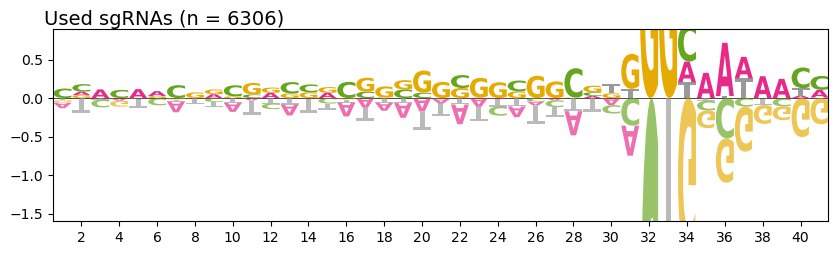

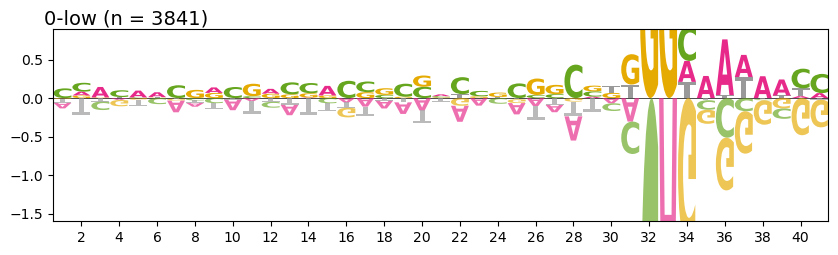

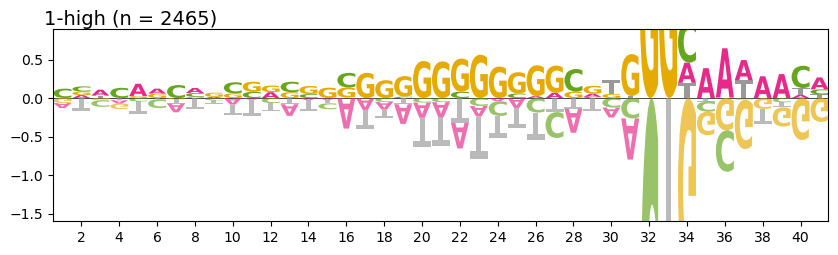

In [32]:
# Logo for ALL sgRNAs combined
ylim_logo = [-1.6, 0.9]
plot_logo(fasta_df_reduced.seq_total, title="Used sgRNAs", ylim=ylim_logo)
plt.savefig("../figures/logo_all.pdf")

# Logo for LOW EFFICIENCY sgRNAs
for i in list_bins:
    plot_logo(
        data=fasta_df_reduced.query('efficiency_binned == "' + i + '"').seq_total,
        title=i,
        ylim=ylim_logo,
    )
    plt.savefig("../figures/logo_" + i + ".pdf")

Conclusions:

- clear relationship of sgRNA sequence and repression efficiency
- high efficiency sgRNAs enriched for 'G' and depleted for 'A' or 'T' in position 4-14 proximal to PAM site
- low efficiency sgRNAs are not enriched for a specific sequence pattern (no neg. selection criterion)
- med efficiency sgRNAs are in fact a mixture of the two above patterns (slight enrichment of 'G' stretch)


## Model 1: Support vector machine

Some useful advice from the scikit-learn page

- Avoiding data copy: Data passed to certain methods will be copied before calling the underlying C implementation. Check if numpy array is C-contiguous by inspecting its flags attribute
- Kernel cache size: has a strong impact on run times for larger problems. If you have enough RAM available, increase cache_size to a higher value
- Setting C: C is 1 by default and it’s a reasonable default choice. If you have a lot of noisy observations you should decrease it
- Larger C values will take more time to train, sometimes up to 10 times longer
- SVM algorithms are not scale invariant, so it is highly recommended to scale your data (scale all features to [0,1] or [-1,+1]. This was done in our example.
- Kernel functions: can be one of linear (most simple), polynomial (`degree`, `coef0`), radial basis function (RBF, `gamma` > 0) or sigmoid (`coef0`)


Important parameters for fitting:

- `kernel`: the main parameter that determines the type of hyperplane for dividing n-D feature vectors
- `n_jobs = -1`: uses all cores instead of 1 (the default)
- `cv`: number of k-fold cross validations, default 5 can be left


In [86]:
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [87]:
# Model tuning
param_grid = {
    "kernel": ["rbf", "linear"],
    "C": [0.5, 0.75, 1, 1.5, 2],
    "gamma": [0.01, 0.05, 0.1, 0.5, 1, 5],
}
SVM = svm.SVC(random_state=42)
SVM_tune = GridSearchCV(SVM, param_grid, n_jobs=-1)
SVM_tune.fit(x_train[:2000], y_train[:2000])
print(SVM_tune.best_params_)

{'C': 1, 'gamma': 0.05, 'kernel': 'rbf'}


In [88]:
# Model fitting & prediction
SVM = svm.SVC(**SVM_tune.best_params_, probability=True, class_weight="balanced")
SVM_fit = SVM.fit(x_train, y_train)
SVM_pred = SVM_fit.predict(x_test)

Evalauation of model performance:

- `precision` = fraction of relevant instances among the retrieved instances (TP/(TP+FP))
- `recall` = fraction of relevant instances that were retrieved (also called sensitivity, TP/(TP+FN))
- `f1-score` = harmonic mean of the precision and recall, best value at 1 and worst at 0
- `specificity` = fraction of non-relevant instances that were retrieved (TN/(TN+FP))
- `accuracy` = fraction of correctly predicted observations out of all observations (TP+TN/(TP+FP+TN+FN))


In [89]:
print("SVM train accuracy: %0.3f" % SVM_tune.score(x_test, y_test))
print(classification_report(y_test, SVM_pred))

SVM train accuracy: 0.631
              precision    recall  f1-score   support

       0-low       0.68      0.71      0.70       971
      1-high       0.50      0.47      0.49       606

    accuracy                           0.62      1577
   macro avg       0.59      0.59      0.59      1577
weighted avg       0.61      0.62      0.62      1577



- test predictive power of the model
- predict classes of validation data set and make confusion matrix


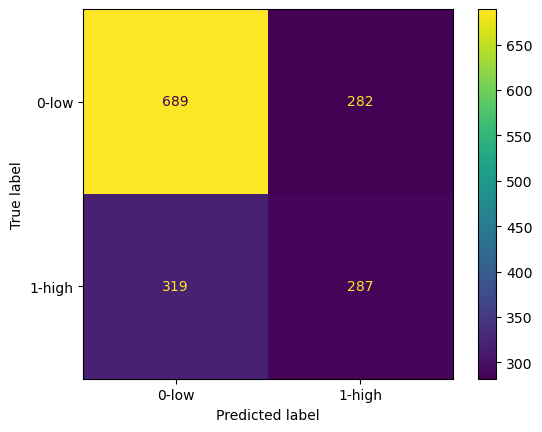

In [90]:
# x-axis: predictions; y-axis: ground truth
SVM_cm = confusion_matrix(y_test, SVM_pred, labels=SVM_fit.classes_)
SVM_cmplot = ConfusionMatrixDisplay(SVM_cm, display_labels=SVM_fit.classes_)
SVM_cmplot.plot()

## Model 2: Random Forest

- Both model types decision tree based, RF with global tree refinement, GBM with local iterative refinement
- Fully tractable models: not only prediction of classes, but also feature importance
- Very important aspect of our question: Which positions/nucleotides of the sgRNA are particularly important?
- This question is almost more important than prediciting quality of sgRNAs, as it can be used to derive generalized rules


In [91]:
from sklearn.ensemble import RandomForestClassifier

In [92]:
# Model tuning
param_grid = {
    "n_estimators": [20, 50, 100, 200, 300, 400],
    "max_features": ["sqrt"],
    "max_depth": [5, 10, 25, 50, 100],
}

RF = RandomForestClassifier(random_state=42)
RF_tune = GridSearchCV(RF, param_grid, n_jobs=-1)
RF_tune.fit(x_train[:2000], y_train[:2000])
print(RF_tune.best_params_)

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 400}


In [93]:
# Model fitting & prediction
RF = RandomForestClassifier(**RF_tune.best_params_, class_weight="balanced")
RF_fit = RF.fit(x_train, y_train)
RF_pred = RF_fit.predict(x_test)

In [94]:
print("RF train accuracy: %0.3f" % RF_tune.score(x_test, y_test))
print(classification_report(y_test, RF_pred))

RF train accuracy: 0.635
              precision    recall  f1-score   support

       0-low       0.67      0.79      0.73       971
      1-high       0.53      0.37      0.44       606

    accuracy                           0.63      1577
   macro avg       0.60      0.58      0.58      1577
weighted avg       0.61      0.63      0.61      1577



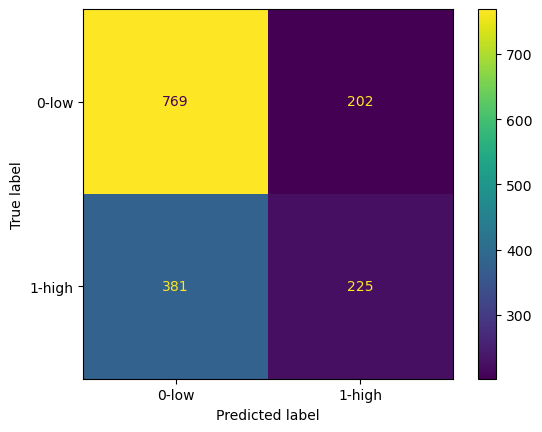

In [95]:
RF_cm = confusion_matrix(y_test, RF_pred, labels=SVM_fit.classes_)
RF_cmplot = ConfusionMatrixDisplay(RF_cm, display_labels=SVM_fit.classes_)
RF_cmplot.plot()

- finally visualize **feature importance** for the RF model
- SVMs and NNs do not have feature importance readily available, they are more black box models
- since the model does not (yet) performs well, the feature importance has not much meaning


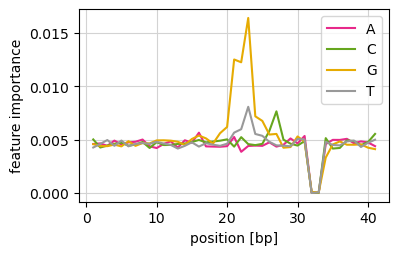

In [96]:
len_sgRNAs = int(fasta_df_reduced["len_total"].aggregate("mean"))

RF_feat_imp = pd.DataFrame()
RF_feat_imp["feat_imp"] = pd.Series(RF_fit.feature_importances_)[0 : (4 * len_sgRNAs)]
RF_feat_imp["position"] = np.repeat(np.arange(len_sgRNAs), 4)
RF_feat_imp["base"] = ["A", "C", "G", "T"] * len_sgRNAs

fig, ax = plt.subplots()
fig.set_size_inches(4, 2.5)
ax.plot(
    np.arange(1, len_sgRNAs + 1),
    RF_feat_imp.query('base == "A"').feat_imp,
    label="A",
    color=colors["A"],
)
ax.plot(
    np.arange(1, len_sgRNAs + 1),
    RF_feat_imp.query('base == "C"').feat_imp,
    label="C",
    color=colors["C"],
)
ax.plot(
    np.arange(1, len_sgRNAs + 1),
    RF_feat_imp.query('base == "G"').feat_imp,
    label="G",
    color=colors["G"],
)
ax.plot(
    np.arange(1, len_sgRNAs + 1),
    RF_feat_imp.query('base == "T"').feat_imp,
    label="T",
    color=colors["T"],
)
ax.set_ylabel("feature importance")
ax.set_xlabel("position [bp]")
ax.legend()
ax.grid(color="lightgrey")
plt.savefig("../figures/plot_rf_feat_importance.svg")

## Model 3: Gradient boosting machine (GBM)

- based on decision trees, similar to RF


In [97]:
from sklearn.ensemble import GradientBoostingClassifier

In [98]:
# Model tuning
param_grid = {
    "loss": ["log_loss", "exponential"],
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.5],
    "max_depth": [1],
}

GBM = GradientBoostingClassifier(random_state=42)
GBM_tune = GridSearchCV(GBM, param_grid, n_jobs=-1)
GBM_tune.fit(x_train[:2000], y_train[:2000])
print(GBM_tune.best_params_)

{'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 1, 'n_estimators': 300}


In [99]:
# Model fitting & prediction
GBM = GradientBoostingClassifier(**GBM_tune.best_params_)
GBM_fit = GBM.fit(x_train, y_train)
GBM_pred = GBM_fit.predict(x_test)

In [100]:
print("GBM train accuracy: %0.3f" % GBM_tune.score(x_test, y_test))
print(classification_report(y_test, GBM_pred))

GBM train accuracy: 0.647
              precision    recall  f1-score   support

       0-low       0.68      0.85      0.75       971
      1-high       0.59      0.34      0.43       606

    accuracy                           0.66      1577
   macro avg       0.63      0.60      0.59      1577
weighted avg       0.64      0.66      0.63      1577



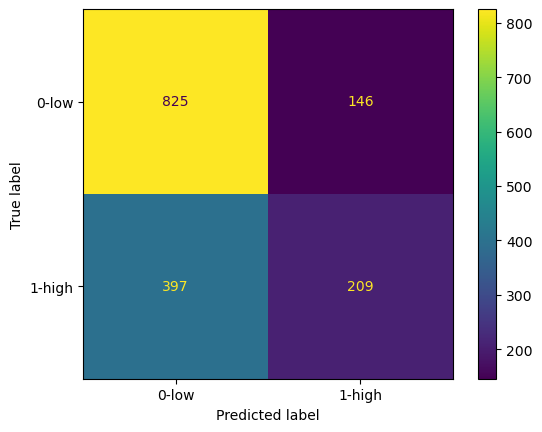

In [101]:
GBM_cm = confusion_matrix(y_test, GBM_pred, labels=SVM_fit.classes_)
GBM_cmplot = ConfusionMatrixDisplay(GBM_cm, display_labels=SVM_fit.classes_)
GBM_cmplot.plot()

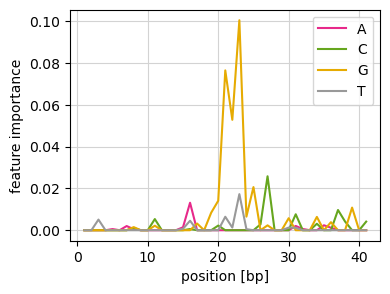

In [102]:
GBM_feat_imp = pd.DataFrame()
GBM_feat_imp["feat_imp"] = pd.Series(GBM_fit.feature_importances_)[0 : (4 * len_sgRNAs)]
GBM_feat_imp["position"] = np.repeat(np.arange(len_sgRNAs), 4)
GBM_feat_imp["base"] = ["A", "C", "G", "T"] * len_sgRNAs

fig, ax = plt.subplots()
fig.set_size_inches(4, 3)
ax.plot(
    np.arange(1, len_sgRNAs + 1),
    GBM_feat_imp.query('base == "A"').feat_imp,
    label="A",
    color=colors["A"],
)
ax.plot(
    np.arange(1, len_sgRNAs + 1),
    GBM_feat_imp.query('base == "C"').feat_imp,
    label="C",
    color=colors["C"],
)
ax.plot(
    np.arange(1, len_sgRNAs + 1),
    GBM_feat_imp.query('base == "G"').feat_imp,
    label="G",
    color=colors["G"],
)
ax.plot(
    np.arange(1, len_sgRNAs + 1),
    GBM_feat_imp.query('base == "T"').feat_imp,
    label="T",
    color=colors["T"],
)
ax.set_ylabel("feature importance")
ax.set_xlabel("position [bp]")
ax.legend()
ax.grid(color="lightgrey")
plt.savefig("../figures/plot_gbm_feat_importance.svg")

Conclusions from all models so far:

- tree based methods performed less good than SVM
- tree-based methods had high recall/senstivity for low-eff sgRNAs, but low recall for high-eff sgRNAs
- feature importance from RF and GBM clearly shows that
- further steps: try a CNN, or try to predict interesting seq features from SVM by probability


## Model 4: Multi-layer perceptron

- for this purpose we try tensorflow + keras
- some background: MLP or other neural networks consist of one or several layers of 'neurons' or nodes
- input data can be multidimensional, in our case it's simply a one-hot-encoded array of i observations x j features
- input features are passed to first layer of NN, transformed by a function, and passed to the next layer
- nodes are highly interconnected so that traits from multiple features get 'recognized' and passed to next layer
- each node generates only one output value $y$ from multiple feature inputs $x$: $y = \sigma \times (\sum(w_i \times x_i) + b)$
- with $x$ being a feature value, $w$ a weight factor, $b$ a learnable bias, and $\sigma$ an activation/cost function)
- training a neural network usually means to vary (optimize) the weight parameter $w$ for each node such that the cost (difference between expected output and obtained output) is minimized
- one difference to the other ML models is that target variable (labels) need to be one hot encoded too
- y therefore needs to be an array with i observations times j number of different labels
- the final layer of the model must have as many nodes as there are labels in the target variable (here: 2, low and high eff.)


In [103]:
from keras import Sequential
from keras import layers
from keras import optimizers
from keras import utils

In [104]:
# preprocess labels: convert to numerical, and also one-hot-encode
# similar to input features (binary output)
y_train_ohe = preprocessing.LabelEncoder().fit_transform(y_train)
y_test_ohe = preprocessing.LabelEncoder().fit_transform(y_test)

y_train_ohe = utils.np_utils.to_categorical(y_train_ohe, num_classes=len(list_bins))
y_test_ohe = utils.np_utils.to_categorical(y_test_ohe, num_classes=len(list_bins))

print(x_train.shape)
print(x_test.shape)
print(y_train_ohe.shape)
print(y_test_ohe.shape)

(4729, 169)
(1577, 169)
(4729, 2)
(1577, 2)


- build model


In [105]:
MLP = Sequential(name="MLP")

# Layer 1
MLP.add(layers.core.Dense(64, activation="relu", input_dim=x_train.shape[1]))

# Layer 2
MLP.add(layers.core.Dense(128, activation="relu"))

# Layer 3
MLP.add(layers.core.Dense(len(list_bins), activation="softmax"))
MLP.compile(
    optimizers.sgd_experimental.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [106]:
print(MLP.summary())

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                10880     
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 19,458
Trainable params: 19,458
Non-trainable params: 0
_________________________________________________________________
None


In [107]:
MLP_fit = MLP.fit(x_train, y_train_ohe, epochs=200, batch_size=32, verbose=False)

In [108]:
MLP.evaluate(x_test, y_test_ohe)
MLP_pred = MLP.predict(x_test)
MLP_pred.shape

50/50 [==============================] - 0s 548us/step


(1577, 2)

              precision    recall  f1-score   support

           0       0.65      0.66      0.65       971
           1       0.44      0.44      0.44       606

    accuracy                           0.57      1577
   macro avg       0.55      0.55      0.55      1577
weighted avg       0.57      0.57      0.57      1577



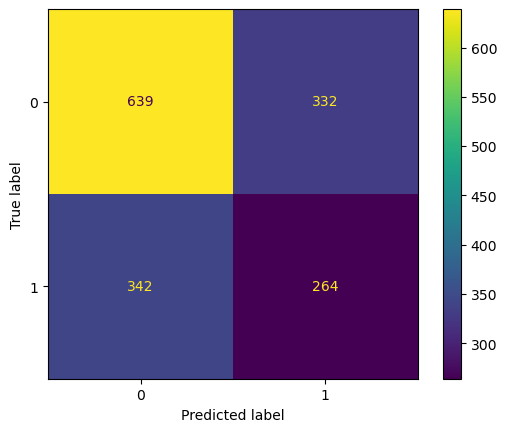

In [109]:
# convert OHE array back to factor with labels
y_test_class = np.argmax(y_test_ohe, axis=1)
y_pred_class = np.argmax(MLP_pred, axis=1)

MLP_cm = confusion_matrix(y_test_class, y_pred_class)
MLP_cmplot = ConfusionMatrixDisplay(MLP_cm)
MLP_cmplot.plot()
print(classification_report(y_test_class, y_pred_class))

<AxesSubplot: >

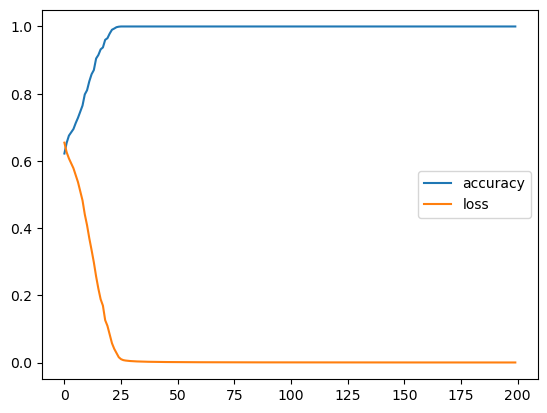

In [110]:
# plot accuracy and loss over model training
df_MLP = pd.DataFrame.from_dict(MLP_fit.history)
df_MLP["accuracy"].plot(legend=True)
df_MLP["loss"].plot(legend=True)

Conclusions:

- best performing models were SVM and MLP
- overall accuracy 60% which is not great
- precision and recall are highest (70%) for low efficency sgRNAs
- precision and recall around 50% for high efficiency sgRNAs


## Summary statistic

- overview in table format about model performance
- precision, recall (sensitivity), accuracy (TP+TN/all)


In [111]:
MLP_pred_bin = y_pred_class
MLP_pred_bin = MLP_pred_bin.astype("str")
MLP_pred_bin[MLP_pred_bin == "0"] = '0-low'
MLP_pred_bin[MLP_pred_bin == "1"] = '1-high'

In [112]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
)

model_stats = pd.DataFrame(columns=["model", "class", "precision", "recall", "accuracy", "f1_score"])
results = {"SVM": SVM_pred, "GBM": GBM_pred, "RF": RF_pred, "MLP": MLP_pred_bin}
for i in results:
    for j in ["0-low", "1-high"]:
        new_row = pd.DataFrame(
            {   
                "model": i,
                "class": j,
                "precision": precision_score(y_test, results[i], pos_label=j),
                "recall": recall_score(y_test, results[i], pos_label=j),
                "accuracy": accuracy_score(y_test, results[i]),
                "f1_score": f1_score(y_test, results[i], pos_label=j),
            },
            index=[0],
        )
        model_stats = pd.concat([model_stats.loc[:], new_row]).reset_index(drop=True)

print(model_stats)

  model   class  precision    recall  accuracy  f1_score
0   SVM   0-low   0.683532  0.709578  0.618897  0.696311
1   SVM  1-high   0.504394  0.473597  0.618897  0.488511
2   GBM   0-low   0.675123  0.849640  0.655675  0.752394
3   GBM  1-high   0.588732  0.344884  0.655675  0.434964
4    RF   0-low   0.668696  0.791967  0.630311  0.725130
5    RF  1-high   0.526932  0.371287  0.630311  0.435624
6   MLP   0-low   0.651376  0.658084  0.572606  0.654713
7   MLP  1-high   0.442953  0.435644  0.572606  0.439268


- receiver operator characteristic (ROC) for the different models
- ROC shows the true positive rate over the false positive rate
- larger area under the curve (AUC) means better model performance

In [113]:
# export stats table
model_stats.to_csv("../data/output/table_ml_stats.csv")

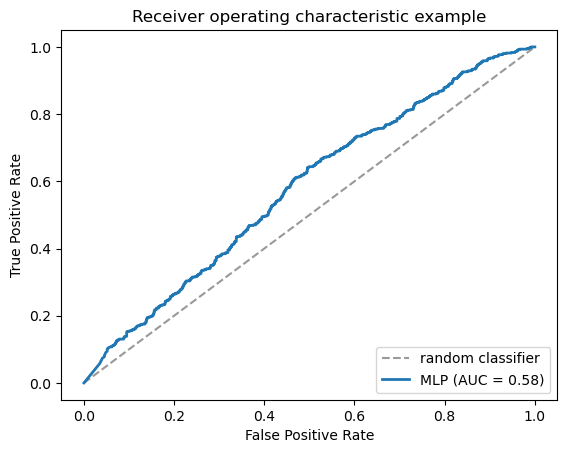

In [114]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, MLP_pred[ : , 1], pos_label="1-high")
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='random classifier')
plt.plot(fpr, tpr, '-', label='MLP (AUC = %0.2f)' % auc(fpr, tpr), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Sequence motifs of high efficiency sgRNAs

- summarize predictions of all models in order to increase high confidence sgRNAs
- inspect sgRNAs with top predicted performance closer
- try to identify sequence patterns that might be enriched using clustering


In [115]:
# retrieve correctly identified sgRNAs from all 4 models (score between 0 and 4)
list_high_eff = (
    (y_test_class == y_pred_class).astype(int)
    + (y_test == SVM_pred).astype(int)
    + (y_test == RF_pred).astype(int)
    + (y_test == GBM_pred).astype(int)
)

print(
    "High effiency sgRNAs in test data identified by at least one model: "
    + str(sum(list_high_eff[y_test_class == 1] >= 1))
)
print(
    "High effiency sgRNAs in test data not identified by any model: "
    + str(sum(list_high_eff[y_test_class == 1] < 1))
)

High effiency sgRNAs in test data identified by at least one model: 404
High effiency sgRNAs in test data not identified by any model: 202


hits
0       202
1       127
2        77
3        96
4       104
dtype: int64


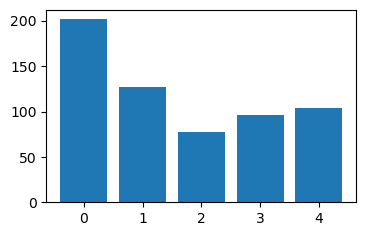

In [116]:
df_ensemble = pd.DataFrame(
    list_high_eff[y_test_class == 1], columns=["hits"]
).value_counts()
df_ensemble = df_ensemble.sort_index()
print(df_ensemble)

fig, ax = plt.subplots()
fig.set_size_inches(4, 2.5)
ax.bar(x=range(df_ensemble.shape[0]), height=df_ensemble)
plt.savefig("../figures/plot_barchart_ML_recall.svg")

In [117]:
# logical with length of test data set indexing subset of
# true positive AND model positive sgRNAs
i_modelpos = i_test[np.logical_and(y_test_class == 1, list_high_eff >= 1)]
i_modelneg = i_test[np.logical_and(y_test_class == 1, list_high_eff < 1)]

/home/michael/micromamba/envs/machine-learning/lib/python3.9/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


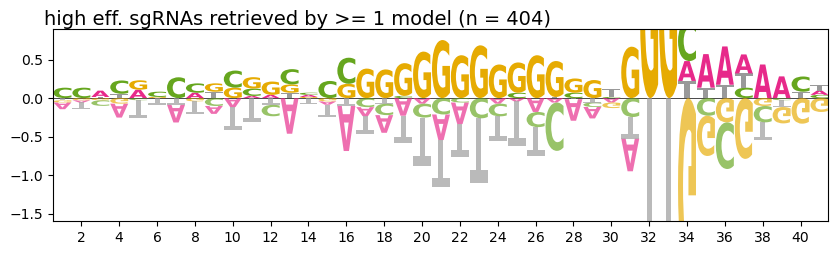

In [118]:
# Logo for high efficiency sgRNAs identified by ML models
plot_logo(
    fasta_df_reduced.iloc[i_modelpos].seq_total,
    title="high eff. sgRNAs retrieved by >= 1 model",
    ylim=ylim_logo,
)

plt.savefig("../figures/logo_ML_1.pdf")

/home/michael/micromamba/envs/machine-learning/lib/python3.9/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


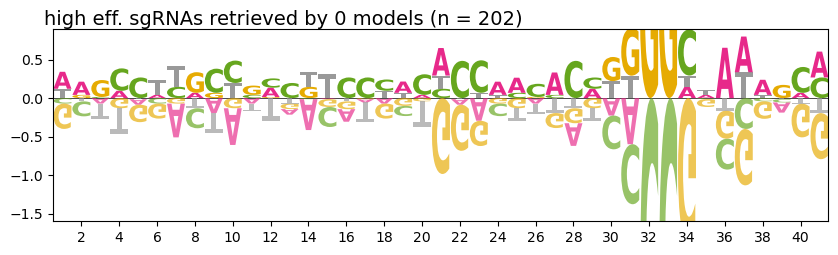

In [119]:
# Logo for high efficiency sgRNAs NOT identified by ML models
plot_logo(
    fasta_df_reduced.iloc[i_modelneg].seq_total,
    title="high eff. sgRNAs retrieved by 0 models",
    ylim=ylim_logo,
)

plt.savefig("../figures/logo_ML_2.pdf")

## Pie charts to summarize sgRNAs used for modeling

Simple pie charts showing fractions of:

- used sgRNAs (genes) vs all sgRNAs (genes) (2 fractions)
- low efficiency vs high efficiency sgRNAs (2 fractions)
- train and test sets, of the latter the model identified and non-identified high eff subset (3 fractions)data


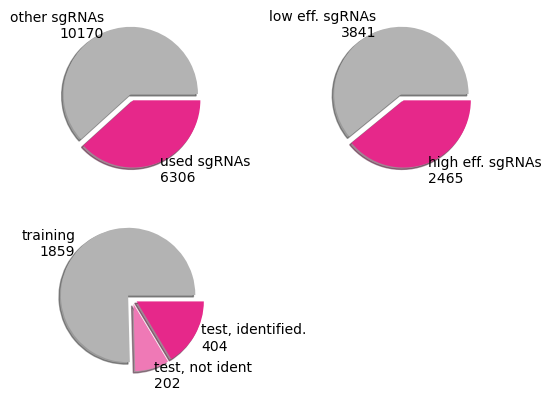

In [120]:
# Make figure and axes
fig, axs = plt.subplots(2, 2)

# Pie 1: total vs used sgRNAs
n_total_sgRNA = len(data.sgRNA.unique())
n_used_sgRNA = len(data_reduced.sgRNA.unique())

axs[0, 0].pie(
    [n_total_sgRNA - n_used_sgRNA, n_used_sgRNA],
    labels=[
        "other sgRNAs\n{}".format(n_total_sgRNA - n_used_sgRNA),
        "used sgRNAs\n{}".format(n_used_sgRNA),
    ],
    shadow=True,
    explode=[0.05, 0.05],
    colors=["#b3b3b3", "#e6288a"],
)

# Pie 2: low vs high eff sgRNAs
n_low_high_sgRNA = data_bin_sum.to_list()
axs[0, 1].pie(
    n_low_high_sgRNA,
    labels=[
        "low eff. sgRNAs\n{}".format(n_low_high_sgRNA[0]),
        "high eff. sgRNAs\n{}".format(n_low_high_sgRNA[1]),
    ],
    shadow=True,
    explode=[0.05, 0.05],
    colors=["#b3b3b3", "#e6288a"],
)

# Pie 3: train and test set, test subdivided in ML+ and ML-
n_train_test = [
    fasta_df_reduced.iloc[i_train].query('efficiency_binned=="1-high"').shape[0],
    len(i_modelneg),
    len(i_modelpos),
]
axs[1, 0].pie(
    n_train_test,
    labels=[
        "training\n{}".format(n_train_test[0]),
        "test, not ident\n{}".format(n_train_test[1]),
        "test, identified.\n{}".format(n_train_test[2]),
    ],
    shadow=True,
    explode=[0.08, 0.08, 0.08],
    colors=["#b3b3b3", "#ef79b6", "#e6288a"],
)

# Hide last position
axs[1, 1].axis("off")

plt.savefig("../figures/piechart_ML.svg")

## Non-sequence feature importance

- apart from the 210 nucleotides that each are a feature, we have 5 more non-binary features
- these are: length of sgRNA, `crisproff` score, melting temp, GC-content, and distance to promoter
- their feature importance is evaluated in comparison to sequence features


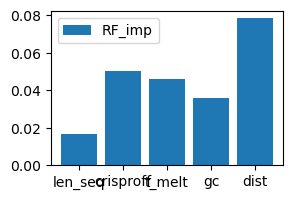

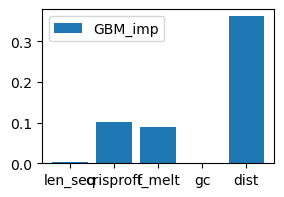

In [121]:
Other_feat_imp = pd.DataFrame()
Other_feat_imp["parameter"] = fasta_df_reduced.columns[[6, 8, 9, 10, 11]]
Other_feat_imp["RF_imp"] = RF_fit.feature_importances_[(4 * len_sgRNAs) :]
Other_feat_imp["GBM_imp"] = GBM_fit.feature_importances_[(4 * len_sgRNAs) :]

for param in ["RF_imp", "GBM_imp"]:
    labels = Other_feat_imp.parameter
    x = np.arange(len(labels))  # the label locations
    fig, ax = plt.subplots()
    fig.set_size_inches(3, 2)
    ax.bar(x, Other_feat_imp.get(param), label=param)
    ax.set_xticks(x, labels)
    ax.legend()
    plt.savefig(f"../figures/plot_{param}_other.svg")

## GC content as efficiency predictor

- it is obvious that some of the "quality" (or efficiency) can be explained by GC content
- as a matter of fact, all high eff sgRNAs seem to have higher GC content from logo pattern

GC content needs to be investigated as a confounding variable, because that alone is a strong predictor compared to sequence motifs.
However if ML models pick GC content up as predictor, it's not wrong, only less useful.

- task 1: compare GC content for high and low efficiency group
- task 2: quantify GC skew and compare between groups
- task 3: if necessary, balance the groups such that average GC content is even


In [122]:
fasta_df_reduced["gc_skew"] = [
    Bio.SeqUtils.GC_skew(i, window=100)[0] for i in fasta_df_reduced.seq
]

Task 1: Average GC content per group:

- high vs low efficiency sgRNAs, total dataset (6400 sgRNAs)
- high efficiency sgRNAs, model-retrieved versus non-retrieved (400 vs 200 sgRNAs)


Mean GC content for 0-low is: 0.53
Mean GC content for 1-high is: 0.55


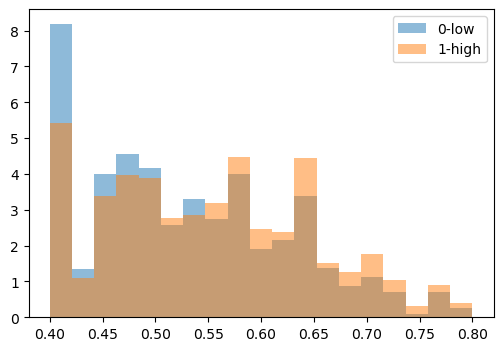

In [123]:
plt.figure(figsize=(6, 4))
for eff in list_bins:
    eff_subset = fasta_df_reduced[fasta_df_reduced.efficiency_binned == eff]["gc"]
    plt.hist(eff_subset, bins=19, alpha=0.5, label=eff, density=True)
    print(
        "Mean GC content for {0} is: {1}".format(eff, str(round(eff_subset.mean(), 2)))
    )
plt.legend(loc="upper right")

Mean GC content for true pos is: 0.56
Mean GC content for false neg is: 0.51


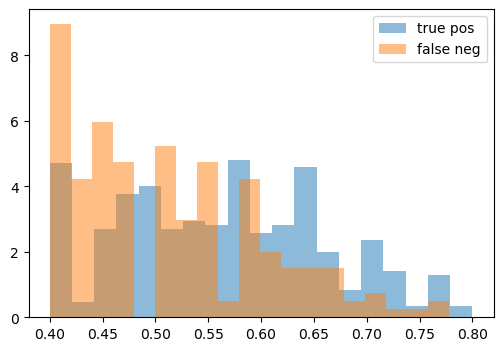

In [124]:
plt.figure(figsize=(6, 4))
dict_groups = {"true pos": i_modelpos, "false neg": i_modelneg}
for group in dict_groups:
    eff_subset = fasta_df_reduced.iloc[dict_groups.get(group)].gc
    plt.hist(eff_subset, bins=19, alpha=0.5, label=group, density=True)
    print(
        "Mean GC content for {0} is: {1}".format(
            group, str(round(eff_subset.mean(), 2))
        )
    )
plt.legend(loc="upper right")

Task 2: GC skew per group

- high vs low efficiency sgRNAs, total dataset (6400 sgRNAs)
- high efficiency sgRNAs, model-retrieved versus non-retrieved (400 vs 200 sgRNAs)


Mean GC skew for 0-low is: -0.02
Mean GC skew for 1-high is: 0.09


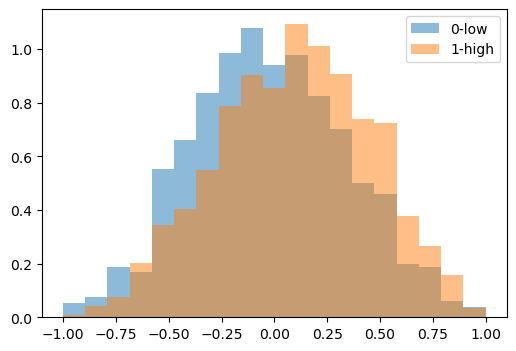

In [125]:
plt.figure(figsize=(6, 4))
for eff in list_bins:
    eff_subset = fasta_df_reduced[fasta_df_reduced.efficiency_binned == eff]["gc_skew"]
    plt.hist(eff_subset, bins=19, alpha=0.5, label=eff, density=True)
    print("Mean GC skew for {0} is: {1}".format(eff, str(round(eff_subset.mean(), 2))))
plt.legend(loc="upper right")

Mean GC skew for true pos is: 0.14
Mean GC skew for false neg is: -0.08


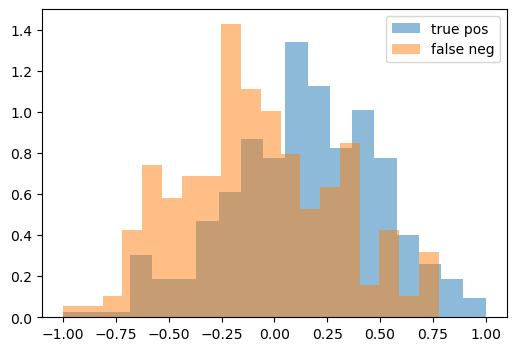

In [126]:
plt.figure(figsize=(6, 4))
for group in dict_groups:
    eff_subset = fasta_df_reduced.iloc[dict_groups.get(group)].gc_skew
    plt.hist(eff_subset, bins=19, alpha=0.5, label=group, density=True)
    print(
        "Mean GC skew for {0} is: {1}".format(group, str(round(eff_subset.mean(), 2)))
    )
plt.legend(loc="upper right")

Test if GC content is significantly different for low and high-efficiency sgRNAs. We use a non-parametric test because the distribution is not normal/gaussian.


In [127]:
from scipy import stats

for metric in ["gc", "gc_skew"]:
    wilcox = stats.ranksums(
        fasta_df_reduced[fasta_df_reduced.efficiency_binned == "0-low"][metric],
        fasta_df_reduced[fasta_df_reduced.efficiency_binned == "1-high"][metric],
        alternative="two-sided",
    )
    print(wilcox)

RanksumsResult(statistic=-8.862823012470178, pvalue=7.80133763695389e-19)
RanksumsResult(statistic=-12.379166770715258, pvalue=3.388422938197536e-35)


The same test for the high efficiency sgRNAs, model-retrieved versus non-retrieved (400 vs 200 sgRNAs)


In [128]:
for metric in ["gc", "gc_skew"]:
    wilcox = stats.ranksums(
        fasta_df_reduced.iloc[dict_groups.get("true pos")][metric],
        fasta_df_reduced.iloc[dict_groups.get("false neg")][metric],
        alternative="two-sided",
    )
    print(wilcox)

RanksumsResult(statistic=6.4555212968263085, pvalue=1.078470122351468e-10)
RanksumsResult(statistic=6.76658331722843, pvalue=1.3185912009967739e-11)


Summary:

- average GC content is 2% higher in high eff. sgRNAs, not substantially
- difference in GC content is small but signigicant (p ~ 10^-20)
- average GC skew (G-C)/(G+C) is -0.02 in low eff sgRNAs, and 0.09 in high eff sgRNAs
- that corresponds to around +1G for every 5C in high eff sgRNAs
- also this difference was highly significant
- average GC content between model-retrieved and non-retrieved high eff sgRNAs is more different (5.5%)
- same for GC skew, difference twice as high as high-vs-low effiency comparison

Conclusion:

- models succeeded to predict high eff sgRNAs _if they have high GC content_ but otherwise not
- we can not say that GC content is the best/only predictor, as the original data set is balanced
- high eff sgRNAs _with low GC content_ apparently evade prediction due to lack of other good features
- the entire data set might be too small to discover all features that determine sgRNA efficiency
